In [1]:
# imports

import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import urllib.request
import ptb_iterator as reader

plt.rc('figure', figsize=(10, 7))

In [2]:
# load and process data

if True:
    file_url = 'https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt'
    file_name = 'tinyshakespeare.txt'

    if not os.path.exists(file_name):
        urllib.request.urlretrieve(file_url, file_name)
else:
    #file_name = 'majakovski.txt'
    file_name = 'vm.txt'

with open(file_name, 'r') as f:
    raw_data = f.read()
    print('Data lenght: {} bytes'.format(len(raw_data)))

vocab = set(raw_data)
vocab_size = len(vocab)
idx_to_vocab = dict(enumerate(vocab))
vocab_to_idx = dict(zip(idx_to_vocab.values(), idx_to_vocab.keys()))

data = [vocab_to_idx[c] for c in raw_data]
del raw_data

Data lenght: 1115394 bytes


In [3]:
# utility functions

def gen_epochs(n, num_steps, batch_size):
    for i in range(n):
        yield reader.ptb_iterator(data, batch_size, num_steps)

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

def restore_or_initialize_session(session, saver, checkpoint):
    session.run(tf.global_variables_initializer())

    if isinstance(checkpoint, str):
        try:
            saver.restore(session, checkpoint)
            return
        except:
            print('Failed to restore from checkpoint: {}'.format(checkpoint))

def train_network(g, num_epochs, num_steps = 200, batch_size = 32, verbose = True, save = False):
    #tf.set_random_seed(2345)

    with tf.Session() as sess:
        # try to restore the graph
        restore_or_initialize_session(sess, g['saver'], save)
        training_losses = []
        
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps, batch_size)):
            training_loss = 0
            steps = 0
            training_state = None
            
            for X, Y in epoch:
                # workaround to avoid mis-shaped inputs
                if X.shape[1] != num_steps or Y.shape[1] != num_steps:
                    continue
                steps += 1
                feed_dict = {g['x']: X, g['y']: Y}
                if training_state is not None:
                    feed_dict[g['init_state']] = training_state
                _, training_loss_, training_state, _ = \
                    sess.run([g['global_step'], g['total_loss'], g['final_state'], g['train_step']],
                             feed_dict)
                training_loss += training_loss_

            if verbose:
                print('avg training loss for epoch {0}: {1:.4f}'.format(idx, training_loss/steps))
            
            training_losses.append(training_loss/steps)

            # I hate dynamic typing....
            if isinstance(save, str):
                g['saver'].save(sess, save, global_step=g['global_step'])

    return training_losses

In [4]:
# cell factory
def create_rnn_cells(cell_type, state_size, num_layers):
    state_is_tuple = False
    
    if cell_type == 'GRU':
        cell_creator = lambda: tf.contrib.rnn.GRUCell(state_size)
    elif cell_type == 'LSTM':
        cell_creator = lambda: tf.contrib.rnn.LSTMCell(state_size, state_is_tuple=True)
        state_is_tuple = True
    else:
        cell_creator = lambda: tf.contrib.rnn.BasicRNNCell(state_size)
        
    cells = [cell_creator() for _ in range(num_layers)]
    return (cells, state_is_tuple)

In [5]:
def build_multilayer_graph(cell_type=None, state_size=100, num_classes=vocab_size, batch_size=32,
        num_steps=200, num_layers=3, learning_rate=1e-4):
    reset_graph()
    
    x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')

    embeddings = tf.get_variable('embedding_matrix', [num_classes, state_size])
    
    # our inputs now is a tensor of dims batch_size x num_steps x state_size
    rnn_inputs = tf.nn.embedding_lookup(embeddings, x)
    
    cells, state_is_tuple = create_rnn_cells(cell_type=cell_type, state_size=state_size, num_layers=num_layers)
    cell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=state_is_tuple)

    init_state = cell.zero_state(batch_size, tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)
    
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, num_classes])
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    
    # reshape rnn outputs and y so we can get the logits in a single matmul
    rnn_outputs = tf.reshape(rnn_outputs, [-1, state_size])
    y_reshaped = tf.reshape(y, [-1])
    
    logits = tf.matmul(rnn_outputs, W) + b
    
    predictions = tf.nn.softmax(logits)
    
    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped))

    global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss, global_step=global_step)

    return dict(x = x, y = y, init_state = init_state, final_state = final_state,
                total_loss = total_loss, train_step = train_step, global_step = global_step,
                preds = predictions, saver = tf.train.Saver())

In [6]:
# network parameters
prefix = 'shksp'
cell_type = 'Basic'
num_steps = 4
batch_size = 32
save_file = 'checkpoints/{0}-{1}_{2}s_{3}bs'.format(prefix, cell_type, num_steps, batch_size)

In [7]:
# build the graph
t = time.time()
g = build_multilayer_graph(cell_type=cell_type, num_steps=num_steps, batch_size=batch_size)
print('It took {} seconds to build the graph'.format(time.time() - t))

It took 1.9392192363739014 seconds to build the graph


In [8]:
# train the network
t = time.time()
losses = train_network(g, num_epochs=3, num_steps=num_steps, batch_size=batch_size, save=save_file)
print('It took {} seconds to train the RNN'.format(time.time() - t))

INFO:tensorflow:Restoring parameters from checkpoints/shksp-Basic_4s_32bs
Failed to restore from checkpoint: checkpoints/shksp-Basic_4s_32bs
avg training loss for epoch 0: 2.3215
avg training loss for epoch 1: 1.9763
avg training loss for epoch 2: 1.8568
It took 188.66267037391663 seconds to train the RNN


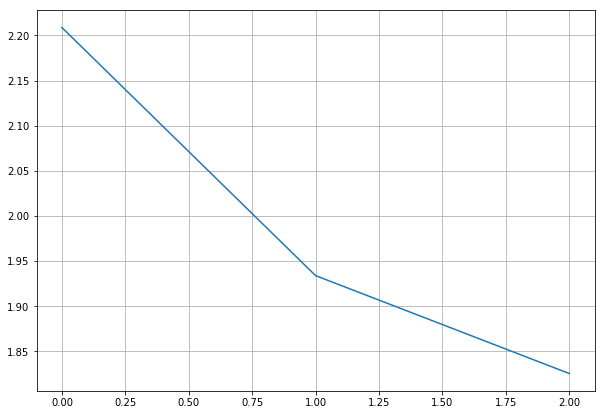

In [10]:
plt.plot(losses)
plt.grid()

## Generating text

In [9]:
def generate_characters(g, checkpoint, num_chars, prompt='A', pick_top_chars=None):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        g['saver'].restore(sess, checkpoint)
        
        state = None
        current_char = vocab_to_idx[prompt]
        chars = [current_char]
        
        for i in range(num_chars):
            feed_dict = {g['x']: [[current_char]]}

            if state is not None:
                feed_dict[g['init_state']] = state
            
            preds, state = sess.run([g['preds'], g['final_state']], feed_dict)
            
            p = np.squeeze(preds)

            if pick_top_chars is not None:
                p[np.argsort(p)[:-pick_top_chars]] = 0
                p = p / np.sum(p)

            current_char = np.random.choice(vocab_size, 1, p=p)[0]
            
            chars.append(current_char)

    chars = map(lambda x: idx_to_vocab[x], chars)
    return "".join(chars)

In [10]:
g = build_multilayer_graph(cell_type=cell_type, num_steps=1, batch_size=1)
print(generate_characters(g, save_file, 512, prompt='a', pick_top_chars=5))

INFO:tensorflow:Restoring parameters from checkpoints/shksp-Basic_4s_32bs


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for checkpoints/shksp-Basic_4s_32bs
	 [[Node: save/RestoreV2_3 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_3/tensor_names, save/RestoreV2_3/shape_and_slices)]]
	 [[Node: save/RestoreV2_18/_49 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_208_save/RestoreV2_18", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save/RestoreV2_3', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.4/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-6a28c532f0b3>", line 1, in <module>
    g = build_multilayer_graph(cell_type=cell_type, num_steps=1, batch_size=1)
  File "<ipython-input-5-f9cd4aecb457>", line 38, in build_multilayer_graph
    preds = predictions, saver = tf.train.Saver())
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 669, in restore_v2
    dtypes=dtypes, name=name)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.4/dist-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for checkpoints/shksp-Basic_4s_32bs
	 [[Node: save/RestoreV2_3 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_3/tensor_names, save/RestoreV2_3/shape_and_slices)]]
	 [[Node: save/RestoreV2_18/_49 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_208_save/RestoreV2_18", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
